In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import FashionMNIST, EMNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
from tqdm import tqdm
import pandas as pd

In [5]:
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
fdataset_train = FashionMNIST(root="./data", train=True, download=True, transform=transform)
fdataset_test = FashionMNIST(root="./data", train=False, download=True, transform=transform)

m = len(fdataset_train)

train_data,val_data = random_split(fdataset_train, [int(m-m*0.2), int(m*0.2)])
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(fdataset_test, batch_size=64, shuffle=True, num_workers=4)

images, labels = next(iter(train_dataloader))
print(f"{images.shape} {labels.shape}")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 1, 28, 28]) torch.Size([64])


In [6]:
device='cuda'
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z      

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [9]:
torch.manual_seed(0)

d = 16

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=16, bias=True)
    (linear3): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): Bat

In [10]:

### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [11]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [12]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = fdataset_test.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = fdataset_test[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  

	 partial train loss (single batch): 30891.345703
	 partial train loss (single batch): 30196.746094
	 partial train loss (single batch): 31444.501953
	 partial train loss (single batch): 31239.468750
	 partial train loss (single batch): 31685.501953
	 partial train loss (single batch): 30511.761719
	 partial train loss (single batch): 29480.789062
	 partial train loss (single batch): 31401.988281
	 partial train loss (single batch): 30903.986328
	 partial train loss (single batch): 30662.320312
	 partial train loss (single batch): 31522.050781
	 partial train loss (single batch): 30914.763672
	 partial train loss (single batch): 30298.574219
	 partial train loss (single batch): 30437.960938
	 partial train loss (single batch): 29404.910156
	 partial train loss (single batch): 29462.123047
	 partial train loss (single batch): 30741.462891
	 partial train loss (single batch): 32872.988281
	 partial train loss (single batch): 31825.611328
	 partial train loss (single batch): 31803.613281


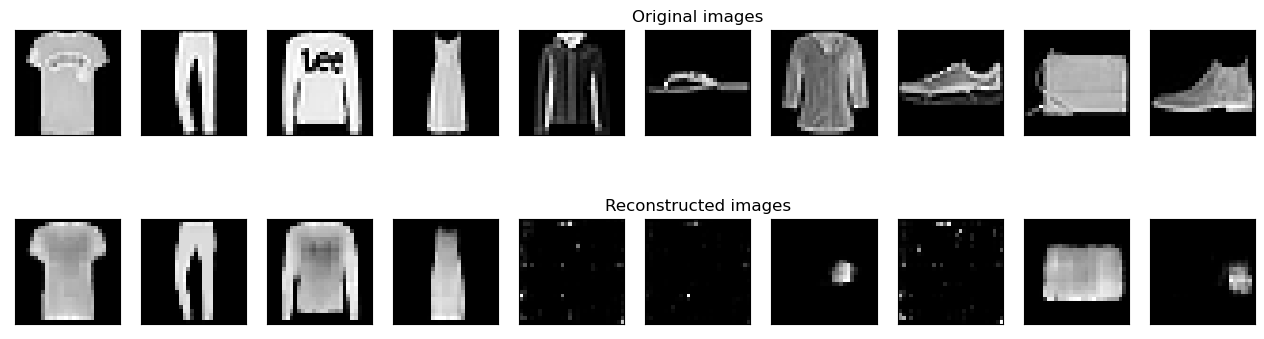

In [13]:
num_epochs = 30

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_dataloader,optim)
   val_loss = test_epoch(vae,device,val_dataloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

In [23]:
def plot_results(iterations = 10):
  sample = fdataset_test[np.random.randint(0,len(fdataset_test))][0].resize(1,1,28,28)

  plt.figure(figsize=(16,4.5))
  vae.eval()
  for i in range(iterations):
    ax = plt.subplot(2,iterations,i+1)
    img = sample.unsqueeze(0).to(device)
    
    # played with the latent space

    with torch.no_grad():
      z = vae.encoder(sample)
    eps = torch.rand((1,16)).to(device)
    ohe = torch.zeros((1,16)).to(device)
    n = np.random.randint(0,16)
    ohe[0][n] = 1
    
    z  += ohe*eps
    with torch.no_grad():
      rec_img = vae.decoder(z)
    
    
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if i == iterations//2:
      ax.set_title('Original images')
    ax = plt.subplot(2, iterations, i + 1 + iterations)
    plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0.5,-0.2, f"dim: {n}", size=12, ha="center", transform=ax.transAxes)
    if i == iterations//2:
        ax.set_title('Reconstructed images')


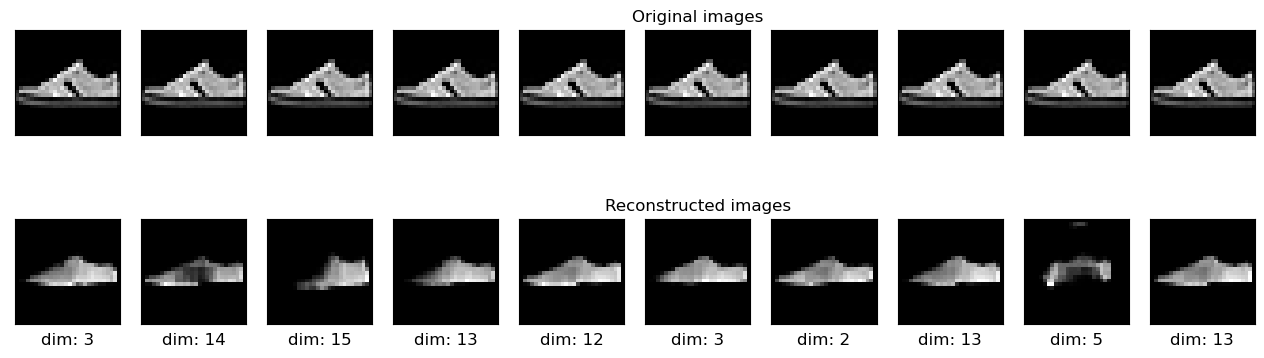

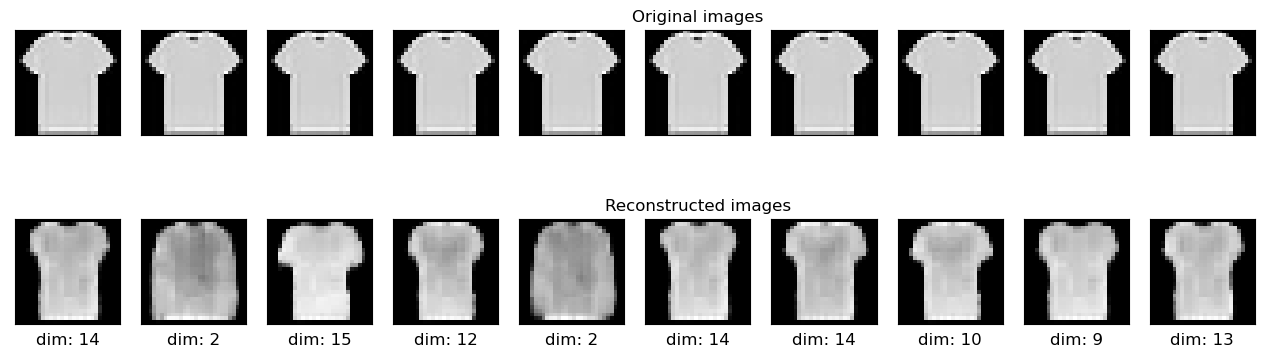

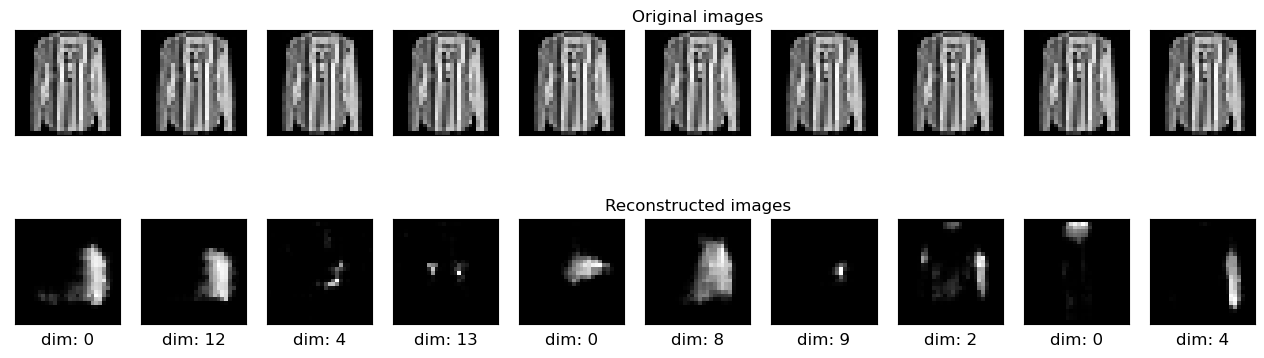

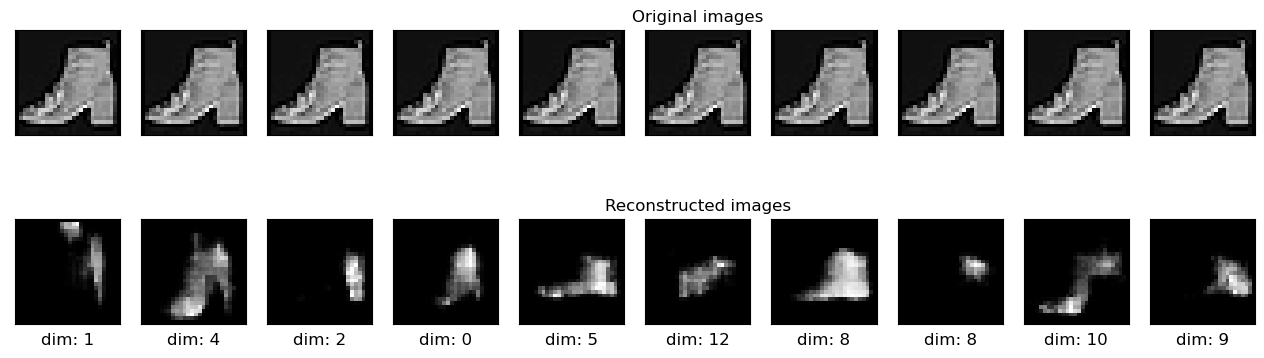

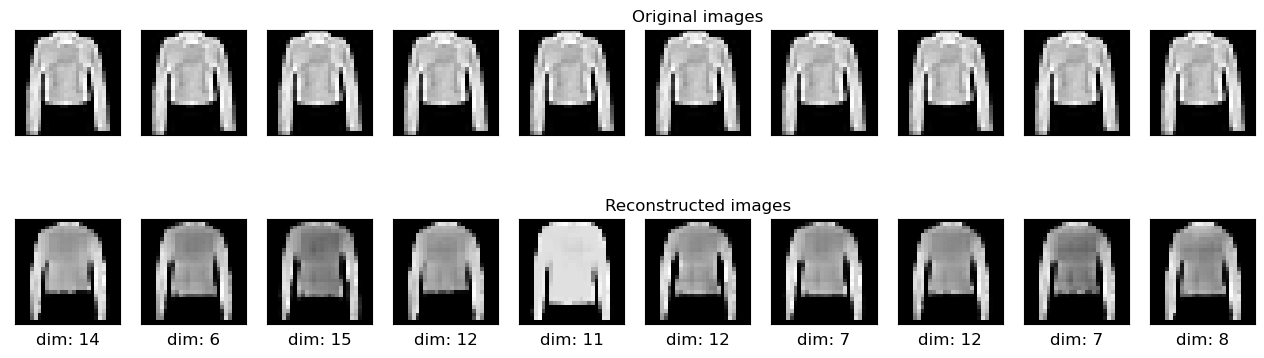

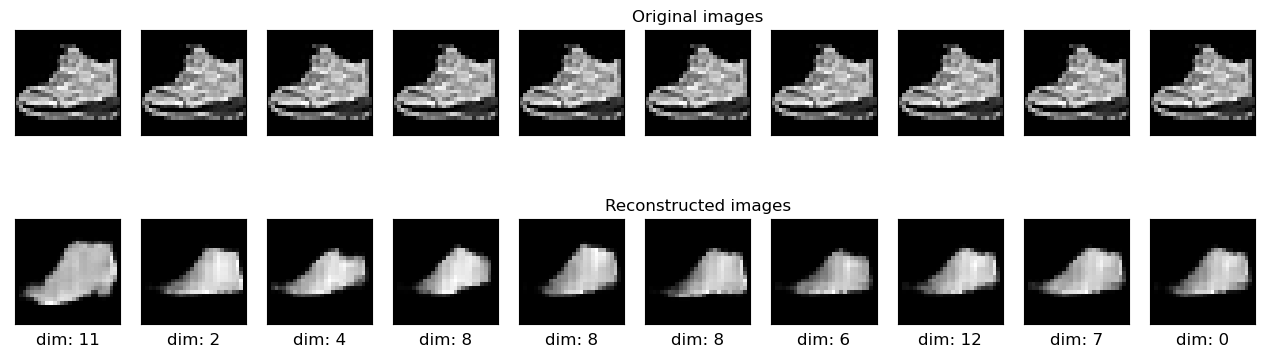

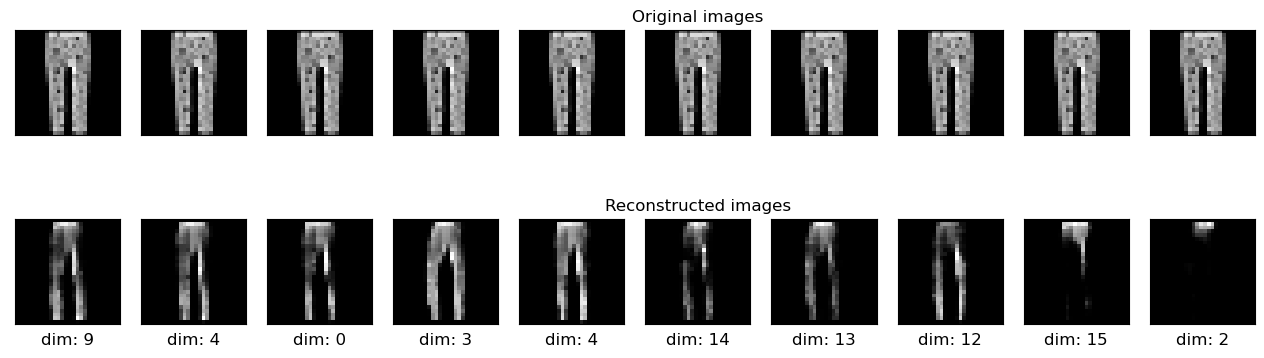

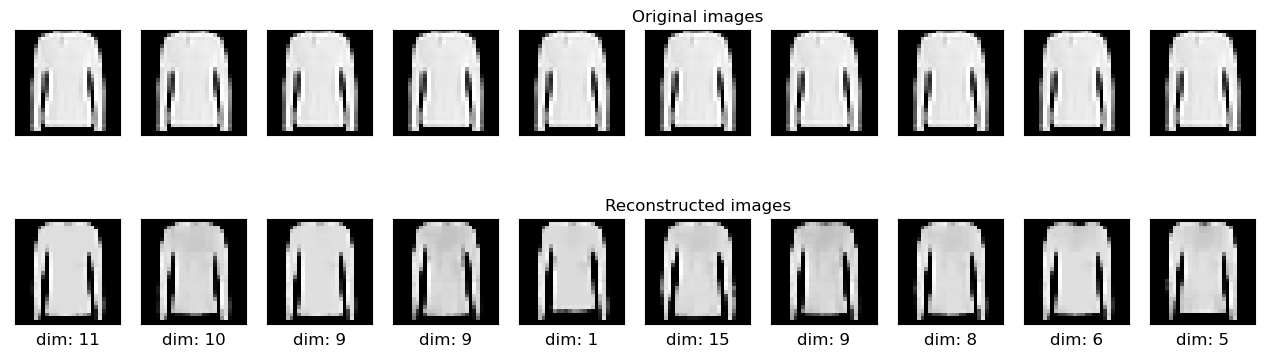

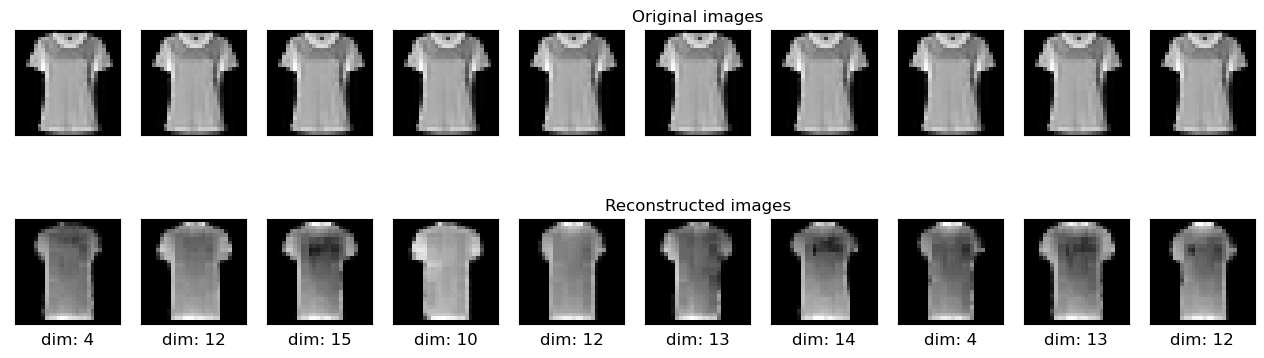

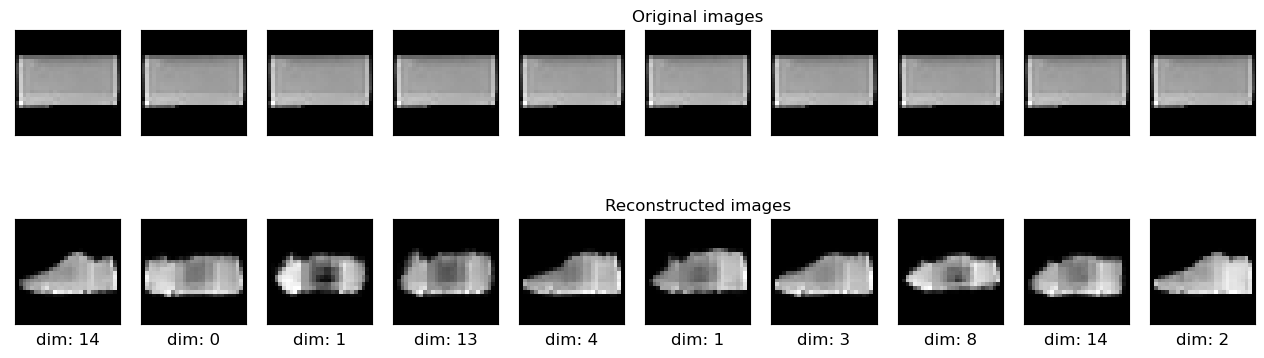

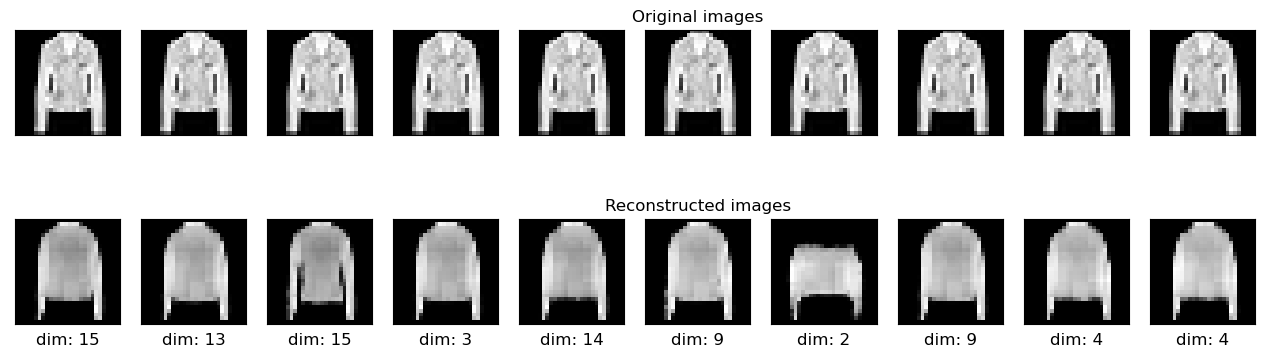

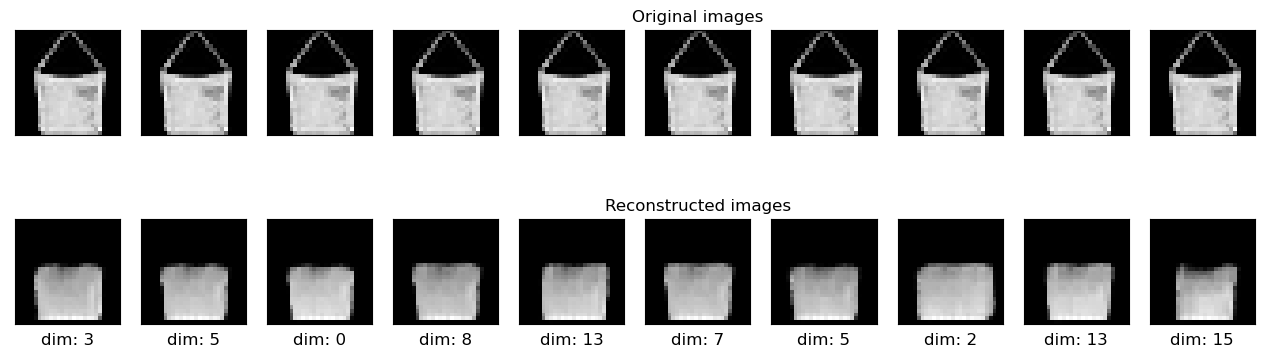

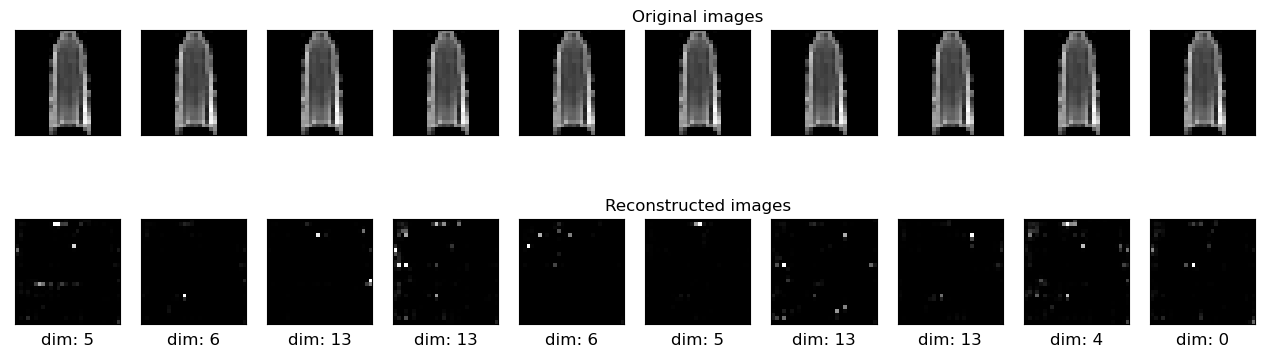

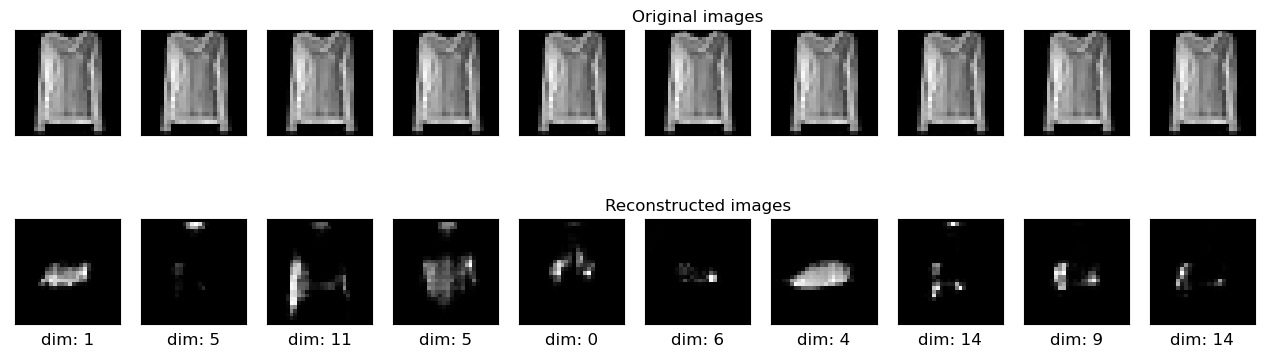

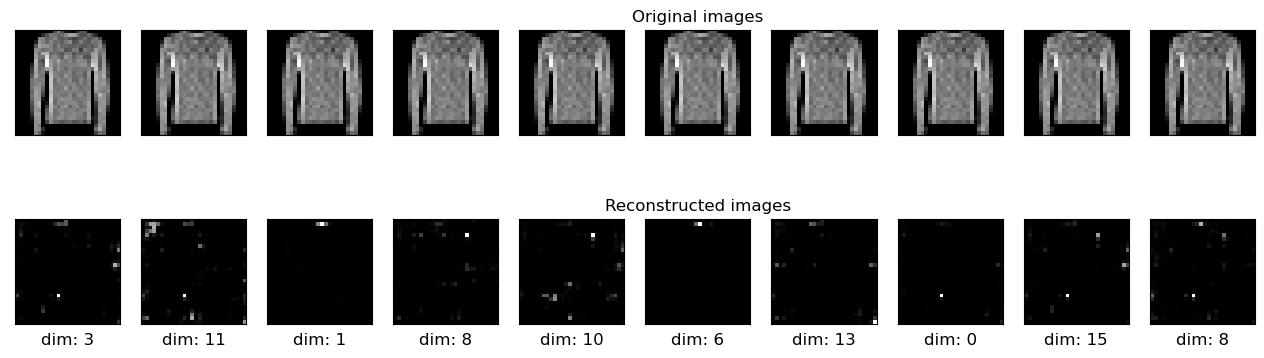

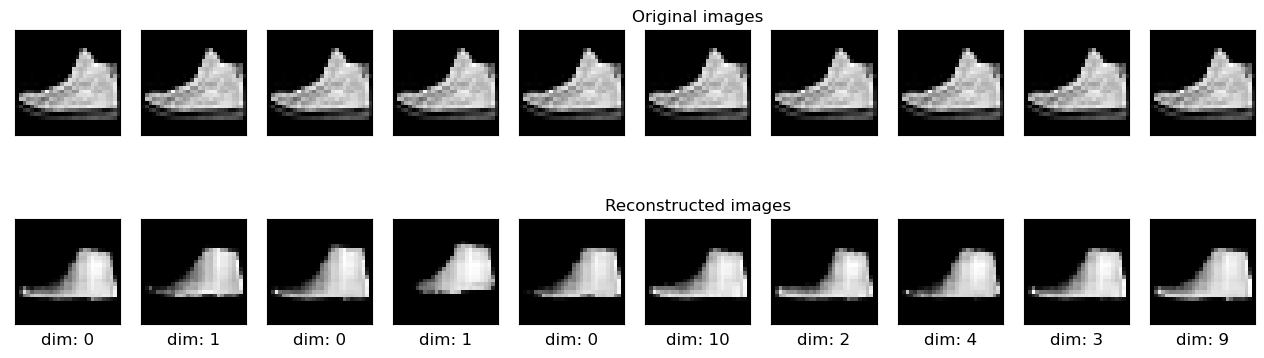

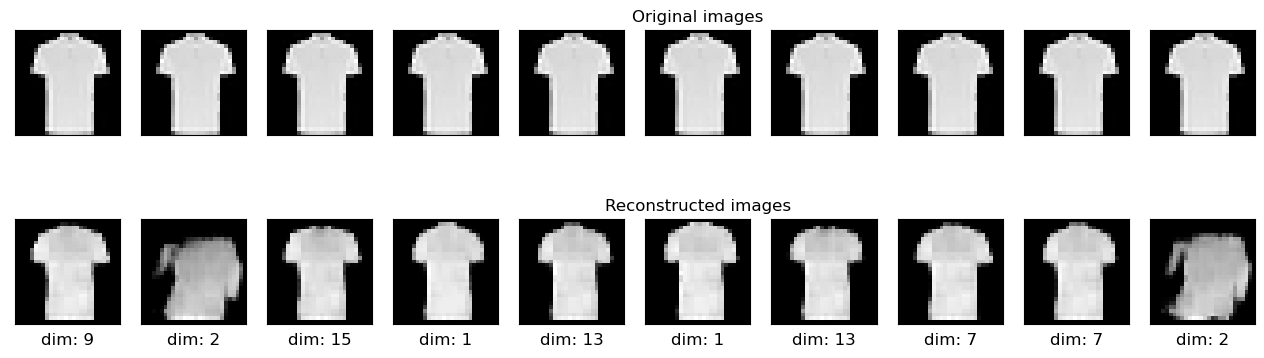

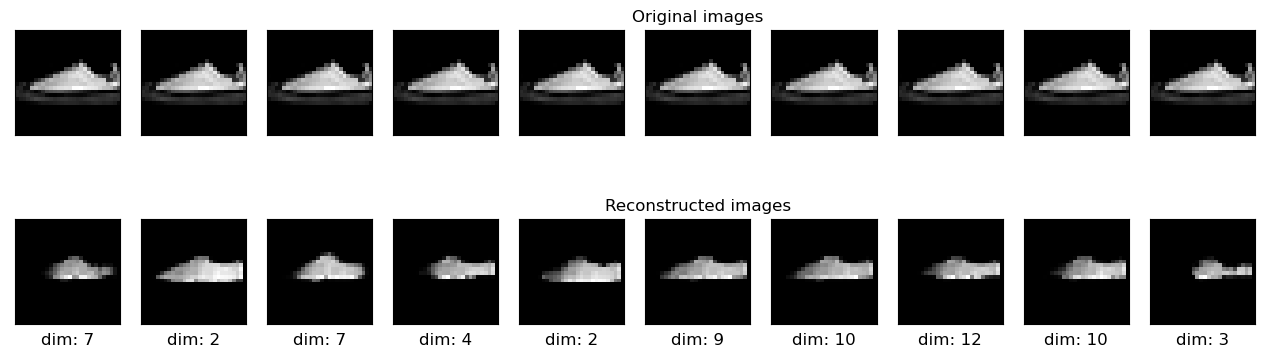

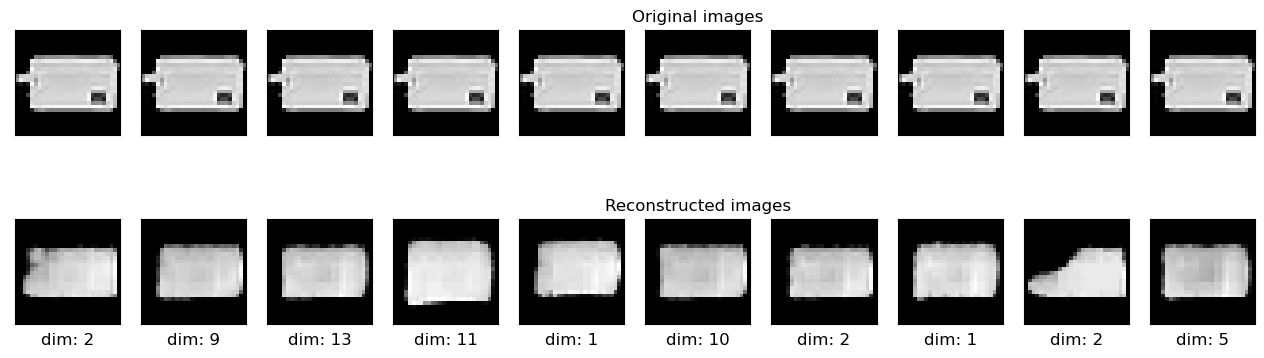

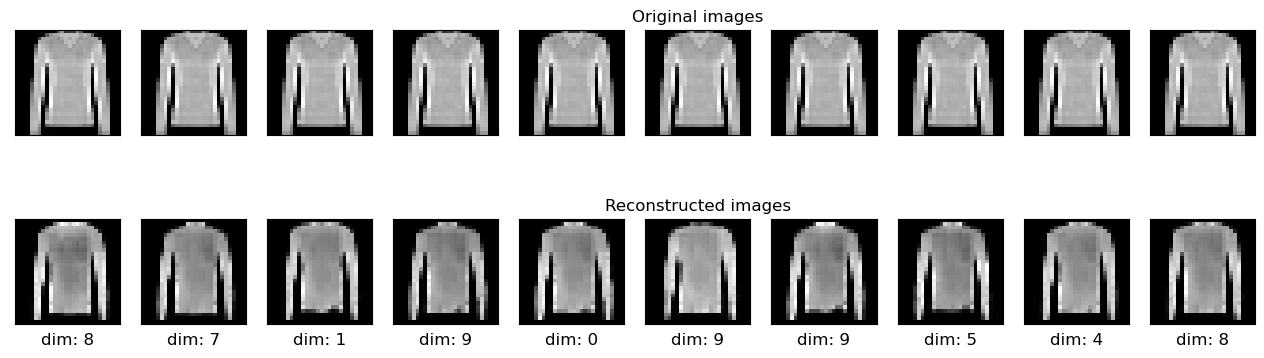

In [24]:
n_images = 20
for i in range(n_images):
  plot_results()

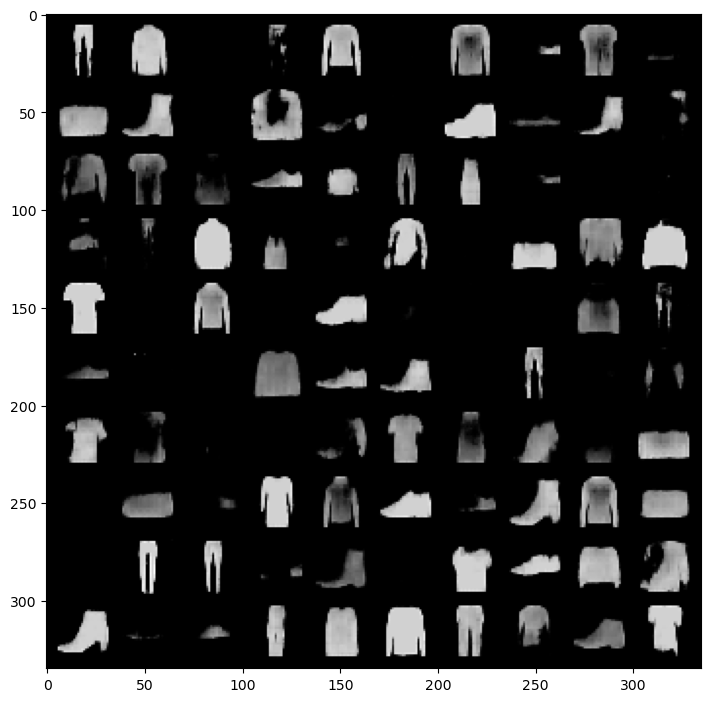

In [27]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

In [34]:
encoded_samples = []
for sample in tqdm(fdataset_test):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)


100%|██████████| 10000/10000 [00:14<00:00, 713.88it/s]


In [35]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [18]:
torch.save(vae,'model')